In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from sklearn.metrics import mean_absolute_error

In [ ]:
#!unzip /content/prices-split-adjusted.csv.zip

In [ ]:
data = pd.read_csv('prices-split-adjusted.csv')

In [ ]:
data.drop(columns=['symbol'], inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
data['Close_scaled'] = scaler.fit_transform(data['close'].values.reshape(-1,1))

In [ ]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data.iloc[0:train_size], data.iloc[train_size:len(data)]

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

In [ ]:
sequence_length = 10
X_train, y_train = create_sequences(train_data[['Close_scaled']].values, sequence_length)
X_test, y_test = create_sequences(test_data[['Close_scaled']].values, sequence_length)

In [ ]:
# Reshape input data for RNN and LSTM models
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Build RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, input_shape=(X_train.shape[1], 1)))
model_rnn.add(Dense(units=1))
model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(X_train, y_train, epochs=3, batch_size=32)


Epoch 1/3
21282/21282 [==============================] - 91s 4ms/step - loss: 0.0017
Epoch 2/3
21282/21282 [==============================] - 84s 4ms/step - loss: 0.0016
Epoch 3/3
21282/21282 [==============================] - 84s 4ms/step - loss: 0.0015


In [ ]:
# Build LSTM model
model_lstm = Sequential()

model_lstm.add(LSTM
 (units=50,
  return_sequences=True,
  input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
21282/21282 [==============================] - 297s 14ms/step - loss: 0.0016
Epoch 2/3
21282/21282 [==============================] - 287s 13ms/step - loss: 7.5908e-04
Epoch 3/3
21282/21282 [==============================] - 296s 14ms/step - loss: 2.7603e-04


In [ ]:
# Predict future prices
def predict_future_prices(model, X):
    predicted_prices = model.predict(X)
    return scaler.inverse_transform(predicted_prices)

In [ ]:
rnn_predictions = predict_future_prices(model_rnn, X_test)
lstm_predictions = predict_future_prices(model_lstm, X_test)

5321/5321 [==============================] - 27s 5ms/step


In [ ]:
# Calculate Mean Absolute Error
rnn_mae = mean_absolute_error(test_data.iloc[sequence_length:, 1], rnn_predictions)
lstm_mae = mean_absolute_error(test_data.iloc[sequence_length:, 1], lstm_predictions)

print("RNN Mean Absolute Error:", rnn_mae)
print("LSTM Mean Absolute Error:", lstm_mae)

RNN Mean Absolute Error: 49.51910450604986
LSTM Mean Absolute Error: 36.210565849615776


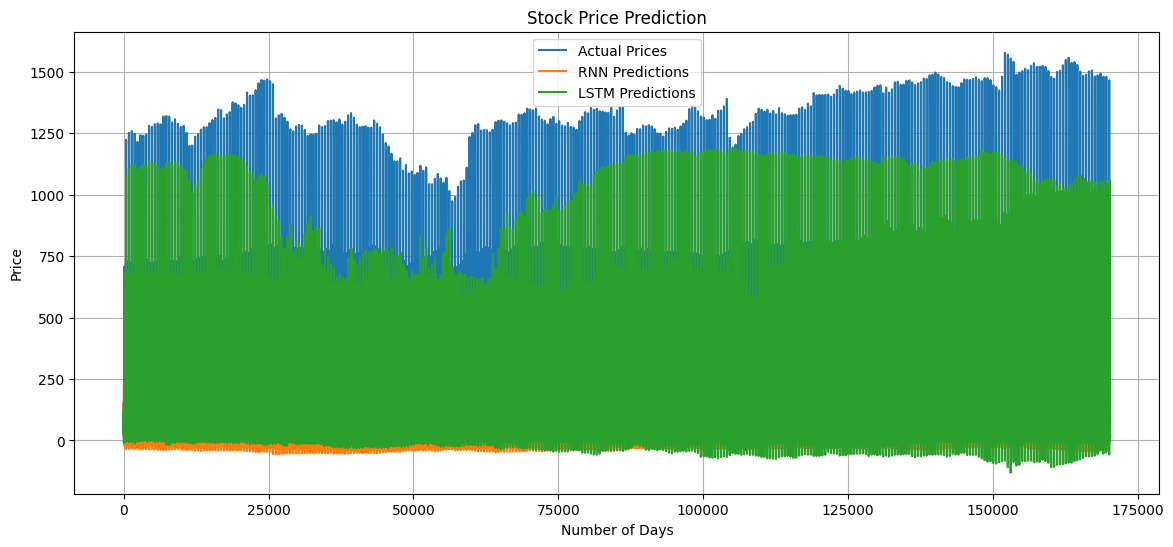

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_data['close'].values[sequence_length:], label='Actual Prices')
plt.plot(rnn_predictions, label='RNN Predictions')
plt.plot(lstm_predictions, label='LSTM Predictions')
plt.xlabel('Number of Days')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.grid(True)
plt.show()